In [ ]:
#!/bin/bash

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [ ]:
! unzip /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
BATCHSIZE = 32
IMGE_SIZE = (224,224)

In [ ]:
train_dir = '/content/seg_train/seg_train'
pred_dir = '/content/seg_pred/seg_pred'
test_dir = '/content/seg_test/seg_test'

In [ ]:
filepaths_train= []
label_train = []
folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir,fold)
    files = os.listdir(foldpath)
    for file in tqdm(files):
        filepath = os.path.join(foldpath,file)
        filepaths_train.append(filepath)
        label_train.append(fold)

100%|██████████| 2404/2404 [00:00<00:00, 435423.71it/s]


In [ ]:
len(filepaths_train)

14034

In [ ]:
df_train = pd.DataFrame(
    {
        'filepath_train': filepaths_train,
        'label_train': label_train
    }
)
filepaths_test= []
label_test = []
folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir,fold)
    files = os.listdir(foldpath)
    for file in tqdm(files):
        filepath = os.path.join(foldpath,file)
        filepaths_test.append(filepath)
        label_test.append(fold)

df_test = pd.DataFrame(
    {
        'filepath_test': filepaths_test,
        'label_test': label_test
    }
)


100%|██████████| 553/553 [00:00<00:00, 481713.42it/s]


In [ ]:
df_train.head(100)


,filepath_train,label_train
0,/content/seg_train/seg_train/mountain/16114.jpg,mountain
1,/content/seg_train/seg_train/mountain/8044.jpg,mountain
2,/content/seg_train/seg_train/mountain/2724.jpg,mountain
3,/content/seg_train/seg_train/mountain/15636.jpg,mountain
4,/content/seg_train/seg_train/mountain/7355.jpg,mountain
...,...,...
95,/content/seg_train/seg_train/mountain/19329.jpg,mountain
96,/content/seg_train/seg_train/mountain/9779.jpg,mountain
97,/content/seg_train/seg_train/mountain/6147.jpg,mountain
98,/content/seg_train/seg_train/mountain/2984.jpg,mountain


In [ ]:
color = ['#FFE1FF','#E4B1F0','#7E60BF','#433878']

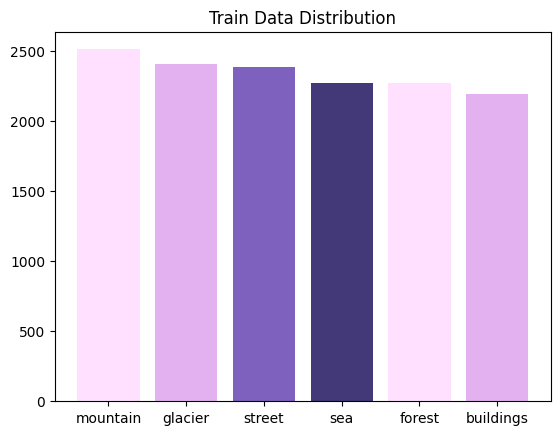

In [ ]:
plt.bar(df_train['label_train'].value_counts().index,df_train['label_train'].value_counts(),color=color)
plt.title('Train Data Distribution')
plt.show()

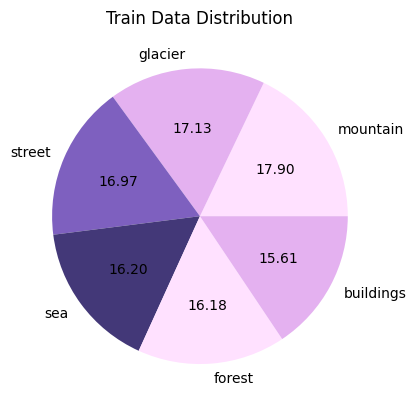

In [ ]:
plt.pie(df_train['label_train'].value_counts(),labels=df_train['label_train'].value_counts().index,colors=color,autopct='%.2f')
plt.title('Train Data Distribution')
plt.show()

In [ ]:
print(df_train['label_train'].value_counts())


label_train
mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: count, dtype: int64


In [ ]:
print(f'this data has {df_train.shape[0]} rows and {df_train.shape[1]} columns')


this data has 14034 rows and 2 columns


In [ ]:
data_gen = ImageDataGenerator(
    rescale=1./255,
)


data_test_gen = ImageDataGenerator(rescale=1./255)





In [ ]:
train_gen = data_gen.flow_from_dataframe(
    df_train,
    x_col='filepath_train',
    y_col='label_train',
    target_size=(IMGE_SIZE[0],IMGE_SIZE[1]),
    class_mode='categorical',
    shuffle=True,
    batch_size=BATCHSIZE,
)

valid_gen = data_gen.flow_from_dataframe(
    df_test,
    x_col='filepath_test',
    y_col='label_test',
    target_size=(IMGE_SIZE[0],IMGE_SIZE[1]),
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCHSIZE,
)

test_gen = data_test_gen.flow_from_dataframe(
    df_test,
    x_col='filepath_test',
    y_col='label_test',
    target_size=(IMGE_SIZE[0],IMGE_SIZE[1]),
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCHSIZE
)

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [ ]:
class_dict = train_gen.class_indices
class_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
for batch_imge, batch_label in train_gen:
    print(batch_imge.shape)
    print(batch_label.shape)
    break

(32, 224, 224, 3)
(32, 6)


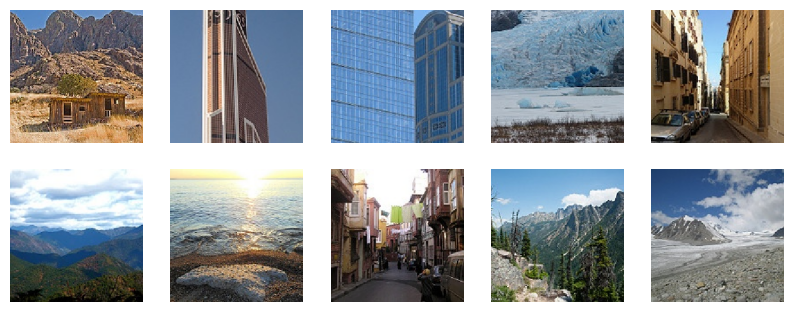

In [ ]:
for batch_imge, batch_label in train_gen:
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(batch_imge[i])
        plt.axis('off')
    break

In [ ]:
Model = Sequential([
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu', input_shape=(IMGE_SIZE[0],IMGE_SIZE[1],3)),
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),


    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax') ])

In [ ]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,896,902 (41.57 MB)

 Trainable params: 10,896,902 (41.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = Model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 189s 370ms/step - accuracy: 0.3110 - loss: 1.5864 - val_accuracy: 0.6027 - val_loss: 0.9743
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 134s 305ms/step - accuracy: 0.6428 - loss: 0.8996 - val_accuracy: 0.7043 - val_loss: 0.7399
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 134s 306ms/step - accuracy: 0.7344 - loss: 0.6977 - val_accuracy: 0.7857 - val_loss: 0.6036
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 134s 306ms/step - accuracy: 0.7949 - loss: 0.5547 - val_accuracy: 0.7430 - val_loss: 0.6670
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 135s 307ms/step - accuracy: 0.8292 - loss: 0.4846 - val_accuracy: 0.8280 - val_loss: 0.5047
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 134s 306ms/step - accuracy: 0.8537 - loss: 0.4134 - val_accuracy: 0.8367 - val_loss: 0.4761
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 307ms/step - accuracy: 0.8692 - loss: 0.3675 - val_accuracy: 0.8483 - val_loss: 0.4540
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 134s 306ms/step - accuracy: 0.8849 -

In [ ]:
print(Model.evaluate(train_gen))
print(Model.evaluate(valid_gen))
print(Model.evaluate(test_gen))

439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.8841 - loss: 0.3270
[0.3184661865234375, 0.8892689347267151]
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8150 - loss: 0.5266
[0.45396390557289124, 0.8483333587646484]
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8150 - loss: 0.5266
[0.45396390557289124, 0.8483333587646484]


In [ ]:
Model.save('Model_intel_ACC87.h5')

In [ ]:
preds = Model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step


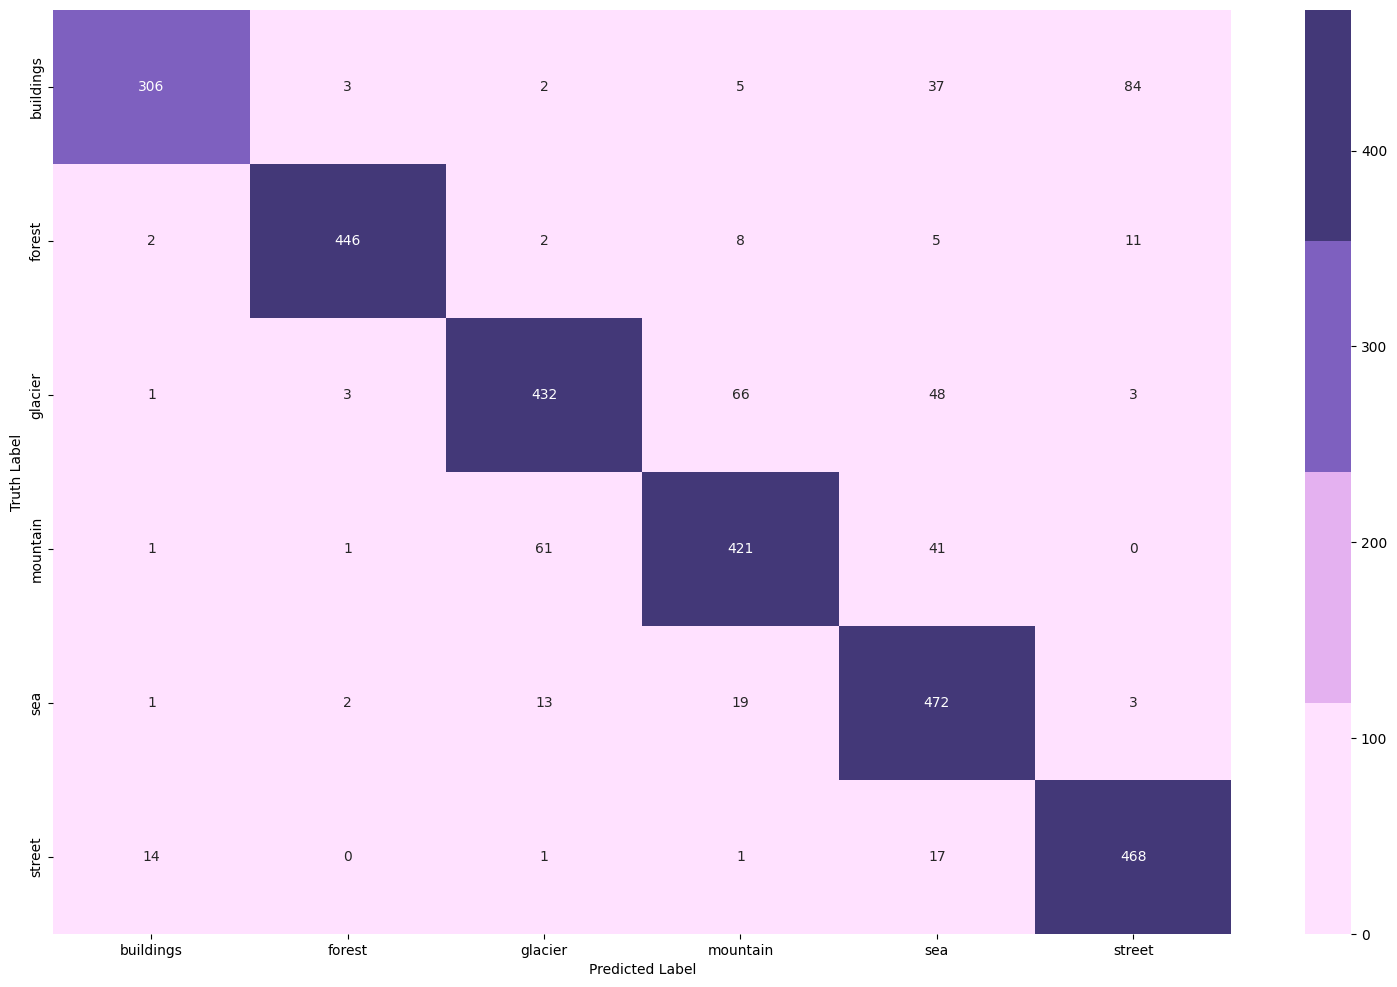

In [ ]:
cm = confusion_matrix(valid_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(19,12))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

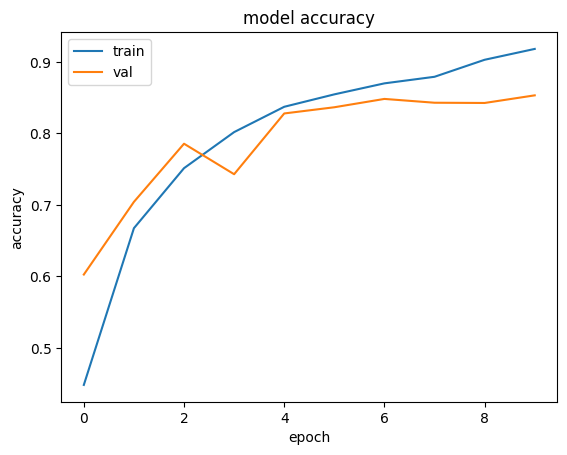

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

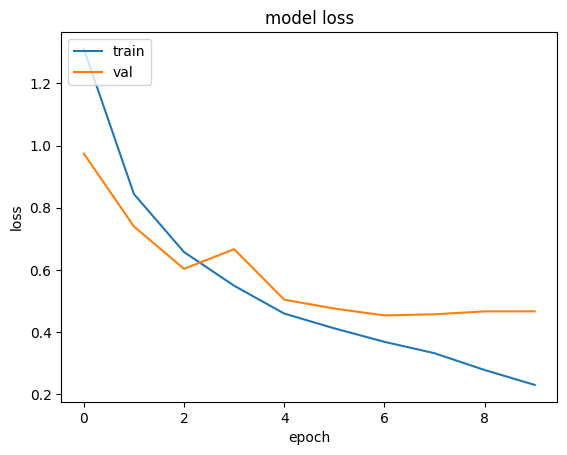

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
def predict(img_path):


    label = list(class_dict.keys())
    plt.figure(figsize=(12, 19))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = Model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


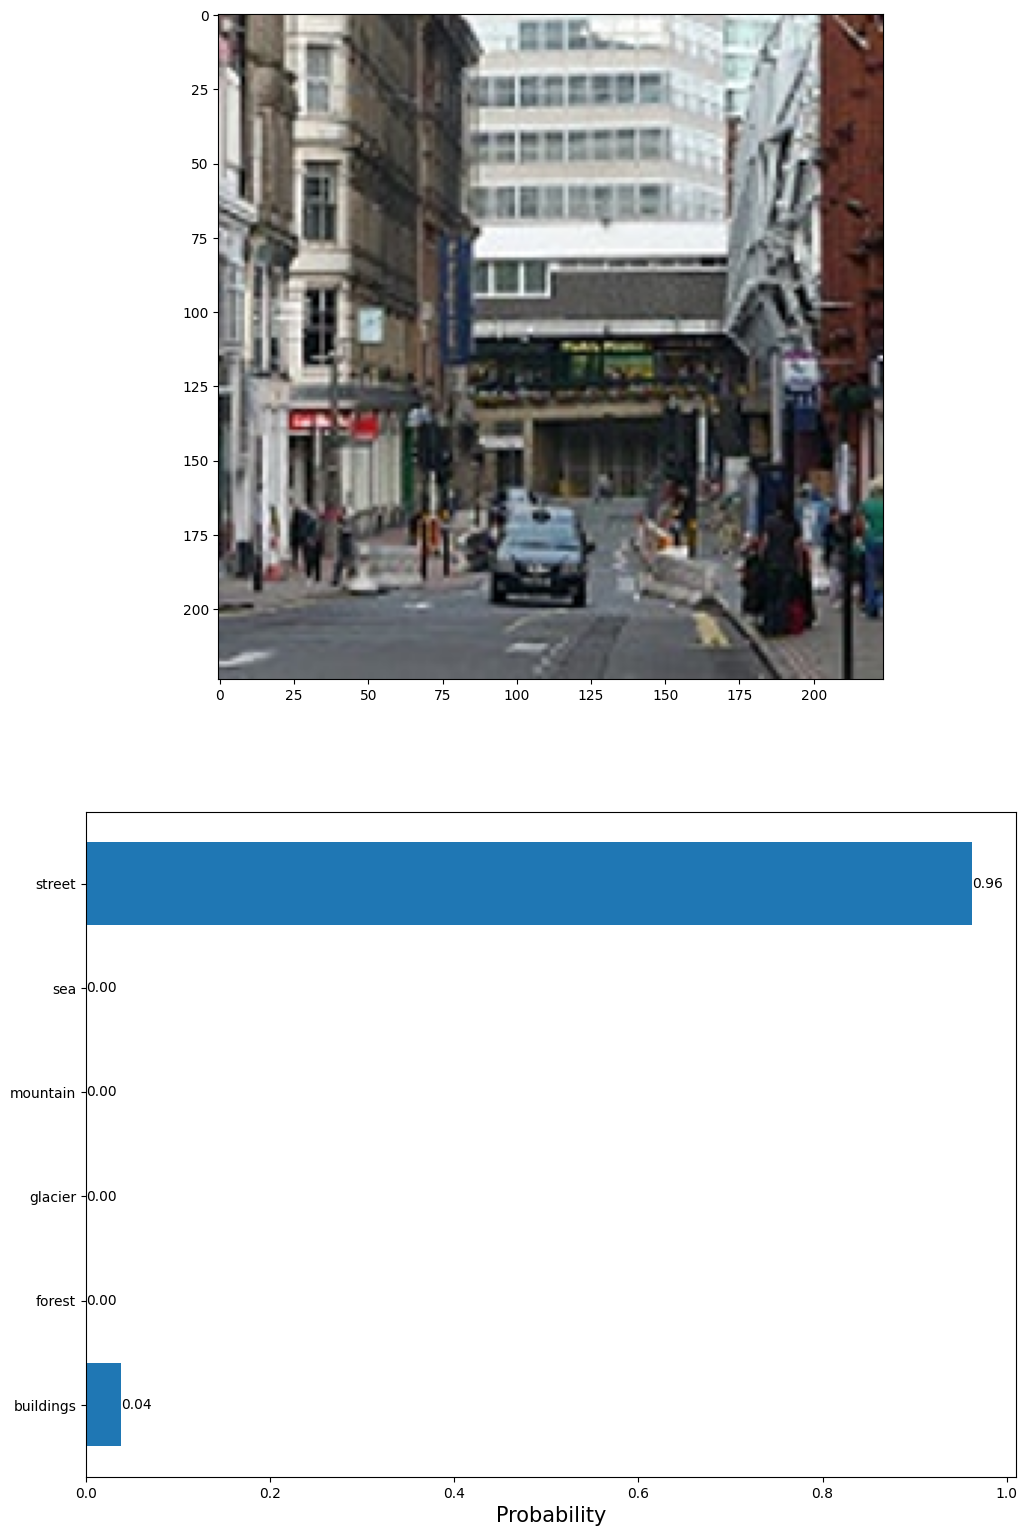

In [ ]:
predict('/content/seg_pred/seg_pred/10012.jpg')
